In [1]:
-- Optical sensor positions
x1 = 0.15 :: Double
x2 = 0.8 :: Double

-- Tables 3.1 & 3.2
data T3 = T3 { mass :: Double, v1 :: Double, v2 :: Double } deriving (Show)
table3_1 = [ T3 { mass = 2.10, v1 = 0.27, v2 = 0.45 }
           , T3 { mass = 2.95, v1 = 0.28, v2 = 0.52 } --0.52v2
           , T3 { mass = 3.80, v1 = 0.32, v2 = 0.62 } --0.62v2
           , T3 { mass = 4.65, v1 = 0.44, v2 = 0.91 } --0.91v2
           , T3 { mass = 5.50, v1 = 0.48, v2 = 0.99 }
           , T3 { mass = 6.35, v1 = 0.57, v2 = 1.08 }
           , T3 { mass = 7.20, v1 = 0.55, v2 = 1.12 } ]

table3_f = (\(T3 m v1 v2) -> T3 m v1 (v2 + 0.1)) <$> table3_1

$$a = \frac{(v_2)^2 - (v_1)^2}{2(x_2 - x_1)}, T = m(g - a)$$

In [2]:
acceleration :: Double -> Double -> Double -> Double -> Double
acceleration v1 v2 x1 x2 = (v2^^2 - v1^^2) / (2.0 * (x2 - x1))

tension :: Double -> Double -> Double
tension m a = m * (g - a)
  where g = 9.82

In [3]:
import Text.Tabular
import qualified Text.Tabular.Html as H
import Text.Html (renderHtml, stringToHtml, (+++))
import IHaskell.Display (DisplayData, html)
import Text.Printf (printf)

printTable :: Table String String String -> DisplayData
printTable = html . renderHtml . (tableCss +++) . tableHtml
  where
    tableCss = H.css H.defaultCss
    tableHtml = H.render stringToHtml stringToHtml stringToHtml

showDouble = printf "%.3f"

table6Head :: Table String String String
table6Head = empty ^..^ colH "$m,\\ г$" ^|^  colH "$a,\\ м/с^2$" ^|^ colH "$T,\\ мН$"

table6 :: [T3] -> Table String String String
table6 = (foldl appendRow table6Head) . (zip [1..])
  where
      appendRow table (n, rowData) = table +.+ (row (show n) (showDouble <$> compute rowData))
      compute (T3 mass v1 v2) = [mass, acc, tension mass acc] where acc = acceleration v1 v2 x1 x2

printTable $ table6 table3_1

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 FINAL//EN">
<!--Rendered using the Haskell Html Library v0.2-->
 table { border-collapse: collapse; border: 1px solid; }
th { padding:0.2em; background-color: #eeeeee }
td { padding:0.2em; }
.thinbottom { border-bottom: 1px solid }
.thickbottom { border-bottom: 3px solid }
.thinright { border-right: 1px solid }
.thickright { border-right: 3px solid }
 $m,\ г$ $a,\ м/с^2$ $T,\ мН$ 1 2.100 0.100 20.413 2 2.950 0.148 28.533 3 3.800 0.217 36.492 4 4.650 0.488 43.393 5 5.500 0.577 50.838 6 6.350 0.647 58.247 7 7.200 0.732 65.432

In [4]:
import Data.List (minimumBy, genericLength)

computedValues :: [T3] -> [(Double, Double)]
computedValues = (go <$>)
  where go (T3 mass v1 v2) = (acc, tension mass acc) where acc = acceleration v1 v2 x1 x2

approximationCoeffs :: [T3] -> (Double, Double)
approximationCoeffs table = (k, b)
  where
    (k, b, _) = minimumBy compareDist [(k, b, avgDist k b) | k <- doubleBetween 40 120, b <- doubleBetween 0 10]
    compareDist (_, _, d1) (_, _, d2) = compare d1 d2
    doubleBetween a b = [int + frac | int <- [a .. b], frac <- [0.0, 0.1 .. 0.9]]
    avgDist k b = sum ds / genericLength ds
      where
        ds = dist <$> (computedValues table) 
        dist (x, y) = abs ((k*x + b)^^2  - y^^2)

interpolateT :: (Double, Double) -> Double -> Double
interpolateT (k, b) a = k * a + b

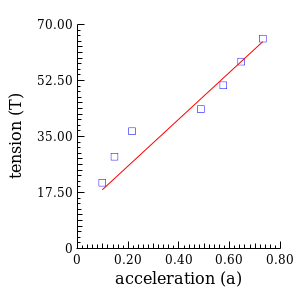

In [5]:
import Graphics.Rendering.Plot
import Numeric.LinearAlgebra (Vector, fromList)
import IHaskell.Display (Display)
import qualified Data.Map as Map
import Data.Text (unpack)

tablePlot :: [T3] -> (Double, Double) -> IO Display
tablePlot table (rangeX, rangeY) = IHaskell.Display.display figure
  where
    approxCs = approximationCoeffs table
    accTension = Map.fromList $ computedValues table
    figure = do
      setPlots 1 1
      withPlot (1,1) $ do
        let xs = fromList $ Map.keys accTension
            ys = fromList $ Map.elems accTension
            interp = fromList $ interpolateT approxCs <$> ((Map.keys accTension) ++ [0])
        setDataset [(Point, xs, ys), (Line, xs, interp)]
        addAxis XAxis (Side Lower) $ do
          withAxisLabel $ setText "acceleration (a)"
        addAxis YAxis (Side Lower) $ do
          withAxisLabel $ setText "tension (T)"
        setRange XAxis Lower Linear 0 rangeX
        setRange YAxis Lower Linear 0 rangeY

tablePlot table3_1 (0.8, 70.0)

In [6]:
massAndError :: [T3] -> (Double, Double) -> (Double, Double)
massAndError table (p_a, p_b) = (mass, err)
  where
    mass = (b_t - a_t) / (b_a - a_a)
    err = (mass / (b_t - a_t)) * sqrt ((2 / (7 - 2)) * sum interpDists)
    interpDists = [ (t - interp a)^^2 | (a, t) <- computedValues table ]
    (a_a, a_t) = (p_a, interp p_a)
    (b_a, b_t) = (p_b, interp p_b)
    interp = interpolateT (approximationCoeffs table)

massAt :: ((Double, Double), (Double, Double)) -> Double
massAt ((a_a, a_t), (b_a, b_t)) = mass
  where
    mass = (b_t - a_t) / (b_a - a_a)

massAt ((0.2, 25.0), (0.8, 69.0))
massAndError table3_1 (0.2, 0.8)

interp = interpolateT (approximationCoeffs table3_1)
(p_a, p_b) = (0.2, 0.8)

(p_a, interp p_a)
(p_b, interp p_b)

approximationCoeffs table3_1
sum [ (t - interp a)^^2 | (a, t) <- computedValues table3_1 ]

73.33333333333333

(73.2,13.428740276160275)

(0.2,25.54)

(0.8,69.46000000000001)

(73.2,10.9)

162.29795886411227